In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load the dataset
columns = [
    'Family Name',
    'Variation',
    'Algorithm Name',
    'Year',
    'Looked at?',
    'Relevant?',
    'Parallel?',
    'Quantum?',
    'Time Complexity Class',
    'Approximation Factor Class (Mult)',
    'Approximation Factor Class (Add)',
    'Approximation Type (additive/multiplicative)',
    'Parametrized Approximation?',
    'Type of PTAS (if PTAS)',
    'Parametrized Approximation?'
]
approximation_algorithms = pd.read_csv(
    'approximation_algorithms.csv', usecols=columns)

# Clean and prepare the data
approximation_algorithms['Year'] = pd.to_numeric(
    approximation_algorithms['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
approximation_algorithms.dropna(subset=['Year'], inplace=True)
approximation_algorithms['Year'] = approximation_algorithms['Year'].astype(int)

# Filter out irrelevant data
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != '0']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != 0]

# # Filter out 0.001 looked at
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0.001']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0']

# # Filter out Parallel algorithms
approximation_algorithms = approximation_algorithms[approximation_algorithms['Parallel?'] != '1']

# # Filter out Quantum algorithms
approximation_algorithms = approximation_algorithms[approximation_algorithms['Quantum?'] != '1']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Quantum?'] != 1]

# if Type of PTAS (if PTAS) is  NaN and Parametrized Approximation? contains yes or yes?, then it is a "parameterized, non-PTAS" algorithm
approximation_algorithms.loc[approximation_algorithms['Type of PTAS (if PTAS)'].isna() & approximation_algorithms['Parametrized Approximation?'].str.contains(
    'yes', case=False, na=False), 'Type of PTAS (if PTAS)'] = 'parameterized, not arbitrarily small'

# if Type of PTAS (if PTAS) is  NaN and Parametrized Approximation? contains no or no?, then it is a "non-parameterized" algorithm
approximation_algorithms.loc[approximation_algorithms['Type of PTAS (if PTAS)'].isna() & approximation_algorithms['Parametrized Approximation?'].str.contains(
    'no', case=False, na=False), 'Type of PTAS (if PTAS)'] = 'non-parameterized'

# remove question mark from Type of PTAS (if PTAS)
approximation_algorithms['Type of PTAS (if PTAS)'] = approximation_algorithms['Type of PTAS (if PTAS)'].str.replace(
    '?', '')


# Sort rows
approximation_algorithms.sort_values(
    by=['Family Name', 'Variation', 'Year'], inplace=True)



In [4]:
print(approximation_algorithms['Type of PTAS (if PTAS)'].value_counts())

# merge all ptas types different from non-parameterized and parameterized, non-PTAS, into "arbitrarily small parameterized error"
approximation_algorithms.loc[~approximation_algorithms['Type of PTAS (if PTAS)'].isin(
    ['non-parameterized', 'parameterized, not arbitrarily small']), 'Type of PTAS (if PTAS)'] = 'PTAS'

# if approximation factor class (add) is 1.99 ant approximation type contains "additive", than Type of PTAS (if PTAS) is "arbitrarily small parameterized error"
approximation_algorithms.loc[(approximation_algorithms['Approximation Factor Class (Add)'] == 1.99) & approximation_algorithms['Approximation Type (additive/multiplicative)'].str.contains(
    'additive', case=False, na=False), 'Type of PTAS (if PTAS)'] = 'Additive Epsilon Error'

print(approximation_algorithms['Type of PTAS (if PTAS)'].value_counts())



Type of PTAS (if PTAS)
parameterized, not arbitrarily small    158
non-parameterized                       101
FPTAS                                    33
FPRAS                                    28
EPTAS                                     8
PTAS                                      3
PRAS                                      1
PRAS                                      1
QPTAS                                     1
EPRAS                                     1
Name: count, dtype: int64
Type of PTAS (if PTAS)
non-parameterized                       101
parameterized, not arbitrarily small     82
PTAS                                     77
Additive Epsilon Error                   76
Name: count, dtype: int64


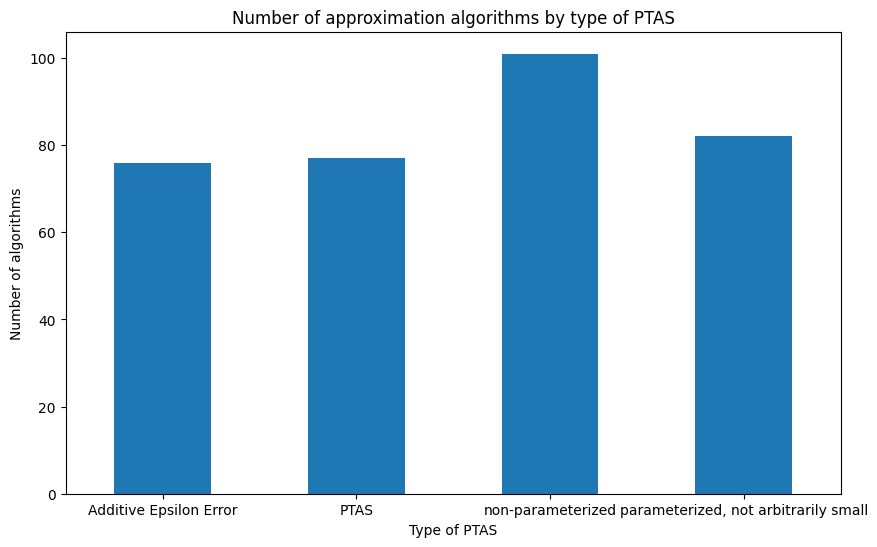

In [5]:
data = approximation_algorithms.copy()

# plot
fig, ax = plt.subplots(figsize=(10, 6))
data.groupby('Type of PTAS (if PTAS)').size().plot(kind='bar', ax=ax)

# rotate x labels
plt.xticks(rotation=0)

plt.xlabel('Type of PTAS')
plt.ylabel('Number of algorithms')
plt.title('Number of approximation algorithms by type of PTAS')
plt.show()

/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12901/350524054.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.groupby('Type of PTAS (if PTAS)').size()


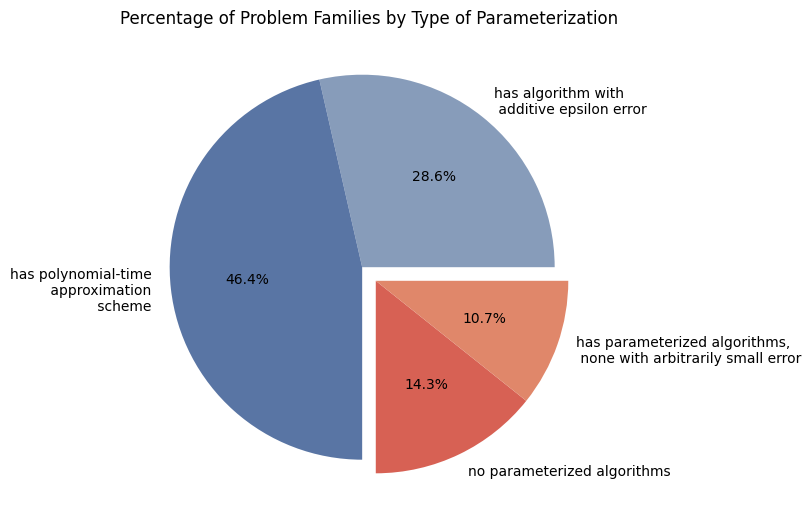

In [6]:
data = approximation_algorithms.copy()

# group by family, if at least one algorithm in the family is arbitrary small parameterized error, then the family is arbitrary small parameterized error
# if at least one algorithm in the family is parameterized, not arbitrarily small, then the family is parameterized, non-PTAS
# if at least one algorithm in the family is non-parameterized, then the family is non-parameterized

data['Type of PTAS (if PTAS)'] = data.groupby('Family Name')['Type of PTAS (if PTAS)'].transform(
    lambda x: 'has polynomial-time\n approximation\n scheme' if 'PTAS' in x.values else (
        'has algorithm with\n additive epsilon error' if 'Additive Epsilon Error' in x.values else (
            'has parameterized algorithms,\n none with arbitrarily small error' if 'parameterized, not arbitrarily small' in x.values else 'no parameterized algorithms'
        )
    )
)

data = data.drop_duplicates(subset=['Family Name', 'Type of PTAS (if PTAS)'])


# sort by type of PTAS
data.sort_values(by='Type of PTAS (if PTAS)', inplace=True)

colors = ['#879CBA', '#5975A4', '#D76154', '#E0876A']

# reoder slices
data['Type of PTAS (if PTAS)'] = pd.Categorical(
    data['Type of PTAS (if PTAS)'], ['has algorithm with\n additive epsilon error','has polynomial-time\n approximation\n scheme','no parameterized algorithms', 'has parameterized algorithms,\n none with arbitrarily small error',])



# plot percentage of families by type of PTAS
fig, ax = plt.subplots(figsize=(10, 6))

data = data.groupby('Type of PTAS (if PTAS)').size()

# pie chart with first 2 slices exploded together
explode = (0.1, 0, 0, 0)

wedges, texts, percs = ax.pie(
    data,
    autopct='%1.1f%%',
    labels=[l for l in data.index],
    colors=colors,
    startangle=0
)

# margin top
ax.margins(0.1)

groups = [[0, 1], [2, 3]]

radfraction = 0.05
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
ax.autoscale(True)

 
plt.text(0, 1.3, 'Percentage of Problem Families by Type of Parameterization', color='black', fontsize=12, ha='center')

plt.show()

# Arbitrarily close (Blue) x Not Arbitrarily close (Red)


In [7]:
# Pie chart (Sheet 1 + Approximation Algorithms)
# category 1: All Family from sheet 1 with no approximation algorithm
# category 2: All Family that have an approximation algorithm but isnt better than exact
# category 3: All Family that have an approximation algorithm and is better than exact

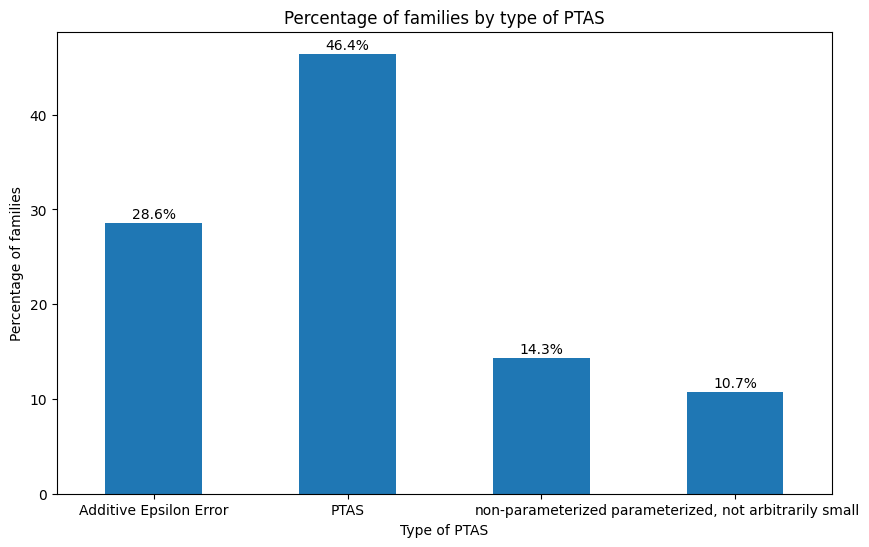

In [8]:
data = approximation_algorithms.copy()

# group by family, if at least one algorithm in the family is arbitrary small parameterized error, then the family is arbitrary small parameterized error
# if at least one algorithm in the family is parameterized, not arbitrarily small, then the family is parameterized, not arbitrarily small
# if at least one algorithm in the family is non-parameterized, then the family is non-parameterized

data['Type of PTAS (if PTAS)'] = data.groupby('Family Name')['Type of PTAS (if PTAS)'].transform(
    lambda x: 'PTAS' if 'PTAS' in x.values else (
        'Additive Epsilon Error' if 'Additive Epsilon Error' in x.values else (
            'parameterized, not arbitrarily small' if 'parameterized, not arbitrarily small' in x.values else 'non-parameterized'
        )
    )
)

data = data.drop_duplicates(subset=['Family Name', 'Type of PTAS (if PTAS)'])



# sort by type of PTAS
data.sort_values(by='Type of PTAS (if PTAS)', inplace=True)



# calculate percentage of families by type of PTAS
percentage = data.groupby('Type of PTAS (if PTAS)').size() / data['Family Name'].nunique() * 100

# plot percentage of families by type of PTAS
fig, ax = plt.subplots(figsize=(10, 6))
# bar plot
percentage.plot(kind='bar', ax=ax)

# add percentage values on top of bars
for i, v in enumerate(percentage):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# rotate x labels
plt.xticks(rotation=0)

plt.xlabel('Type of PTAS')
plt.ylabel('Percentage of families')

plt.title('Percentage of families by type of PTAS')

plt.show()

/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_12901/503755988.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data.groupby('Type of PTAS (if PTAS)').size()


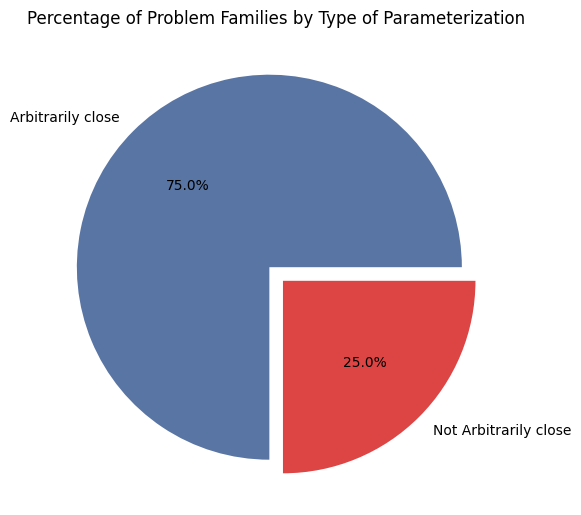

In [13]:


data = approximation_algorithms.copy()

# group by family, if at least one algorithm in the family is arbitrary small parameterized error, then the family is arbitrary small parameterized error
# if at least one algorithm in the family is parameterized, not arbitrarily small, then the family is parameterized, non-PTAS
# if at least one algorithm in the family is non-parameterized, then the family is non-parameterized

data['Type of PTAS (if PTAS)'] = data.groupby('Family Name')['Type of PTAS (if PTAS)'].transform(
    lambda x: 'Arbitrarily close' if 'PTAS' in x.values else (
        'Arbitrarily close' if 'Additive Epsilon Error' in x.values else (
            'Not Arbitrarily close' if 'parameterized, not arbitrarily small' in x.values else 'Not Arbitrarily close'
        )
    )
)

data = data.drop_duplicates(subset=['Family Name', 'Type of PTAS (if PTAS)'])


# sort by type of PTAS
data.sort_values(by='Type of PTAS (if PTAS)', inplace=True)

colors = ['#5975A4', '#DD4444']

# reoder slices
data['Type of PTAS (if PTAS)'] = pd.Categorical(
    data['Type of PTAS (if PTAS)'], ['Arbitrarily close','Not Arbitrarily close'])



# plot percentage of families by type of PTAS
fig, ax = plt.subplots(figsize=(10, 6))

data = data.groupby('Type of PTAS (if PTAS)').size()

# pie chart with first 2 slices exploded together
explode = (0.1, 0,)

wedges, texts, percs = ax.pie(
    data,
    autopct='%1.1f%%',
    labels=[l for l in data.index],
    colors=colors,
    startangle=0
)

# margin top
ax.margins(0.1)

groups = [[0], [1]]

radfraction = 0.05
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
ax.autoscale(True)

 
plt.text(0, 1.3, 'Percentage of Problem Families by Type of Parameterization', color='black', fontsize=12, ha='center')

plt.show()

# New Graph


In [ ]:
# New Graph
# Pie chart (Sheet 1 + Approximation Algorithms)
# category 1: All Family from sheet 1 with no approximation algorithm
# category 2: All Family that have an approximation algorithm but isnt better than exact
# category 3: All Family that have an approximation algorithm and is better than exact

